In [37]:
import numpy as np

# Create a Generator using MT19937
bitgen = np.random.MT19937(seed=42)
rng = np.random.Generator(bitgen)

# Use this generator to sample
print(rng.uniform(0, 1, 1))  # Now uses seeded MT19937

[0.54199389]


In [38]:
#import numpy as np
import random
import heapq
from scipy.stats import t
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import copy


#### Simulation of hospital bed occupancy during burn-in period ( 30 days)
We simulates how hospital bed occupancy evolves during the burn-in period, helping to assess when the system stabilizes before proper data collection begins. 

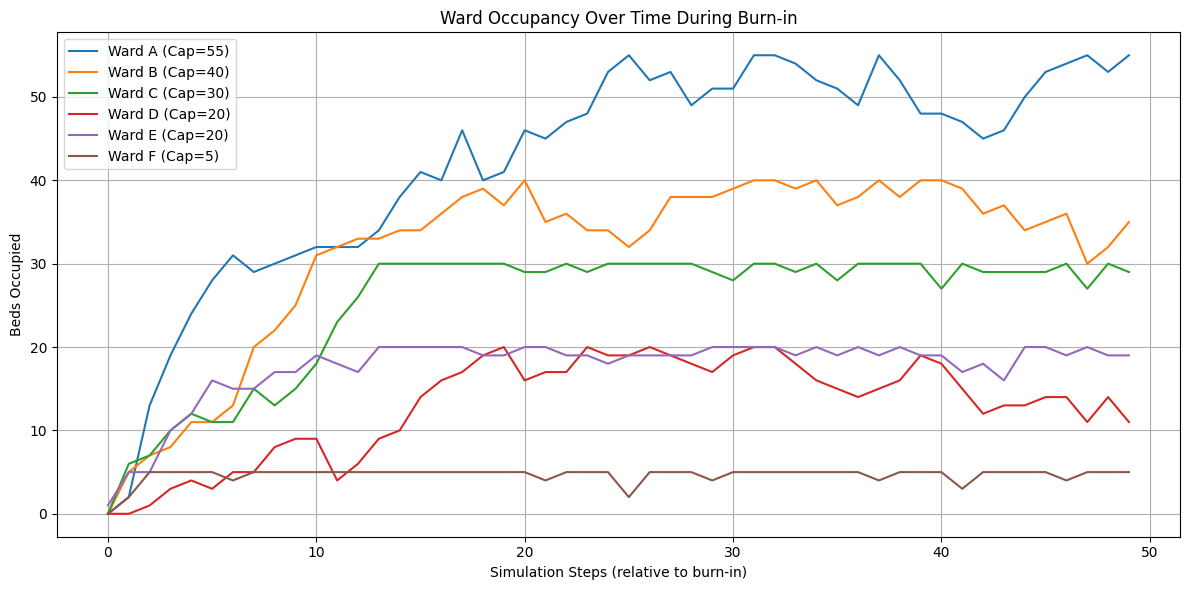

In [39]:


def simulate_burnin_occupancy(n=3000, burn_in=1000, capacity=None, lambda_rates=None, mu_rates=None, P=None, track_time=50):
    """
    Simulates hospital ward occupancy over time to determine burn-in period.
    Returns occupancy time series for each ward.
    """
    if capacity is None:
        capacity = [55, 40, 30, 20, 20, 5]
    if lambda_rates is None:
        lambda_rates = [14.5, 11.0, 8.0, 6.5, 5.0, 13.0]
    if mu_rates is None:
        mu_rates = [1/2.9, 1/4.0, 1/4.5, 1/1.4, 1/3.9, 1/2.2]
    if P is None:
        P = np.array([
            [0.0, 0.05, 0.10, 0.05, 0.80, 0.0],
            [0.20, 0.0, 0.50, 0.15, 0.15, 0.0],
            [0.30, 0.20, 0.0, 0.20, 0.30, 0.0],
            [0.35, 0.30, 0.05, 0.0, 0.30, 0.0],
            [0.20, 0.10, 0.60, 0.10, 0.0, 0.0],
            [0.20, 0.20, 0.20, 0.20, 0.20, 0.0]
        ])

    m = len(capacity)
    max_capacity = max(capacity)
    beds = np.full((m, max_capacity), np.nan)
    for i in range(m):
        beds[i, :capacity[i]] = 0  # initialize all usable beds to free

    occupancy_time_series = [[] for _ in range(m)]
    current_time = 0

    for i in range(burn_in):
        arrival_time = np.random.exponential(1 / sum(lambda_rates))
        current_time += arrival_time
        beds = np.where(np.isnan(beds), np.nan, beds - arrival_time)

        patient_type = np.random.choice(m, p=np.array(lambda_rates) / sum(lambda_rates))
        assigned_ward = patient_type
        los = np.random.exponential(1 / mu_rates[patient_type])

        bed_index = np.nanargmin(beds[assigned_ward])
        bed_time = beds[assigned_ward, bed_index]

        if bed_time <= 0:
            beds[assigned_ward, bed_index] = los
        else:
            assigned_ward = np.random.choice(m, p=P[patient_type])
            bed_index = np.nanargmin(beds[assigned_ward])
            bed_time = beds[assigned_ward, bed_index]
            if bed_time <= 0:
                beds[assigned_ward, bed_index] = los
            # else lost (not tracked here)

        if i % (burn_in // track_time) == 0:
            for j in range(m):
                occ = np.sum(beds[j, :] > 0)
                occupancy_time_series[j].append(occ)

    return occupancy_time_series, capacity

# Run and plot
occupancy_time_series, capacity = simulate_burnin_occupancy()
wards = ['A', 'B', 'C', 'D', 'E', 'F']

plt.figure(figsize=(12, 6))
for i, series in enumerate(occupancy_time_series):
    plt.plot(series, label=f"Ward {wards[i]} (Cap={capacity[i]})")
plt.xlabel("Simulation Steps (relative to burn-in)")
plt.ylabel("Beds Occupied")
plt.title("Ward Occupancy Over Time During Burn-in")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Simulates Patient Flow in Hospital
We simulates patient flow through a hospital with multiple wards (A–E, optionally F) over a period of days. It models patient arrivals, admissions, transfers, and losses due to full capacity. Here's what it does:

In [41]:
#Determine if F should be included or not. Write FALSE or TRUE
INCLUDE_F = False  # Set to True to include Ward F
WARDS = ['A', 'B', 'C', 'D', 'E'] + (['F'] if INCLUDE_F else [])

# Given Parameters

arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
stay_means = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
initial_beds = {'A': 55, 'B': 40, 'C': 30, 'D': 20, 'E': 20, 'F': 0}
relocation_probs = {
    'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
    'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
    'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
    'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
    'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
    'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
}

# Initialization Function
def initialize_events(days=395):
    event_list = []
    np.random.seed(0)
    for ptype in WARDS:
        # no. of arrivals to simulate
        num_arrivals = int( arrival_rates[ptype] * days) #  * 1.2 argument for buffer
        # mean time between arrivals
        mean_interarrival_time = 1 / arrival_rates[ptype]
        # Generate interarrival time
        interarrival_times = np.random.exponential(mean_interarrival_time, num_arrivals)
        arrivals = np.cumsum(interarrival_times)
        for t in arrivals:
            if t < days:
                heapq.heappush(event_list, (t, 'Arr', ptype))
    return event_list

# Event Handling
def handle_arrival(event, bed, stay_means, penalties, blocked, event_list,
                   patients_total, patients_admitted, patients_relocated, patients_lost,
                   bed_full_events, burnin):
    time, _, ptype = event
    if time >= burnin:
        patients_total[ptype] += 1

    if bed[ptype] > 0:
        bed[ptype] -= 1
        los = np.random.exponential(stay_means[ptype]) # length of stay
        heapq.heappush(event_list, (time + los, 'Dep', ptype))
        if time >= burnin:
            patients_admitted[ptype] += 1
    else: # If no bed is available
        dests = list(relocation_probs[ptype].keys())
        probs = list(relocation_probs[ptype].values())
        dest = random.choices(dests, probs)[0] #We randomly choose a destination ward based on these prob
        heapq.heappush(event_list, (time, 'Tra', (ptype, dest)))  # same time for transfer
        if time >= burnin:
            bed_full_events[ptype] += 1
            penalties[ptype] += urgency_points[ptype]

    return bed, penalties, blocked

def handle_departure(event, bed):
    _, _, ptype = event
    bed[ptype] += 1
    return bed


def handle_transfer(event, bed, stay_means, penalties, blocked, event_list,
                    patients_relocated, patients_lost, patients_admitted, burnin):
    time, _, (from_type, dest) = event
    if bed[dest] > 0:
        bed[dest] -= 1
        if time >= burnin:
            patients_relocated[from_type] += 1
        los = np.random.exponential(stay_means[from_type])
        heapq.heappush(event_list, (time + los, 'Dep', dest))
    else:
        if time >= burnin:
            patients_lost[from_type] += 1
            blocked += 1

    return bed, penalties, blocked

# Main Simulation Function
def simulate_hospital_flow(days=395, burnin=30):
    bed = initial_beds.copy()
    penalties = {w: 0 for w in WARDS}
    blocked = 0
    event_list = initialize_events(days)

    patients_total = {w: 0 for w in WARDS}
    patients_admitted = {w: 0 for w in WARDS}
    patients_relocated = {w: 0 for w in WARDS}
    patients_lost = {w: 0 for w in WARDS}
    bed_full_events = {w: 0 for w in WARDS}


    while event_list:
        event = heapq.heappop(event_list)
        event_type = event[1]

        if event_type == 'Arr':
            bed, penalties, blocked = handle_arrival(
            event, bed, stay_means, penalties, blocked, event_list,
            patients_total, patients_admitted, patients_relocated, patients_lost, bed_full_events, burnin)


        elif event_type == 'Dep':
            bed = handle_departure(event, bed)

        elif event_type == 'Tra':
            bed, penalties, blocked = handle_transfer(
            event, bed, stay_means, penalties, blocked, event_list,
            patients_relocated, patients_lost, patients_admitted, burnin)


    # Compute metrics
    fraction_direct = {
        w: patients_admitted[w] / patients_total[w] if patients_total[w] > 0 else 0
        for w in WARDS
    }
    prob_full = {
        w: bed_full_events[w] / patients_total[w] if patients_total[w] > 0 else 0
        for w in WARDS
    }

    # Output results
    print("\n--- Simulation Results ---")
    for w in WARDS:
        print(f"Ward {w}")
        print(f"  N: patients   = {patients_total[w]}")
        print(f"  N: directly admitted   = {patients_admitted[w]}")
        print(f"  N: relocated  = {patients_relocated[w]}")
        print(f"  N: lost       = {patients_lost[w]}")
        print(f"  Penalty       = {penalties[w]}")
        print(f"  Fraction Directly Admitted        = {fraction_direct[w]:.4f}")
        print(f"  Probability Beds Full on Arrival  = {prob_full[w]:.4f}")
    print(f"\nTotal blocked patients: {blocked}")

    return (patients_total, patients_admitted, patients_relocated, patients_lost, penalties, blocked)

# ▶ Run it
simulate_hospital_flow()



--- Simulation Results ---
Ward A
  N: patients   = 5282
  N: directly admitted   = 4963
  N: relocated  = 163
  N: lost       = 156
  Penalty       = 2233
  Fraction Directly Admitted        = 0.9396
  Probability Beds Full on Arrival  = 0.0604
Ward B
  N: patients   = 4003
  N: directly admitted   = 3151
  N: relocated  = 609
  N: lost       = 243
  Penalty       = 4260
  Fraction Directly Admitted        = 0.7872
  Probability Beds Full on Arrival  = 0.2128
Ward C
  N: patients   = 2901
  N: directly admitted   = 1849
  N: relocated  = 843
  N: lost       = 209
  Penalty       = 2104
  Fraction Directly Admitted        = 0.6374
  Probability Beds Full on Arrival  = 0.3626
Ward D
  N: patients   = 2370
  N: directly admitted   = 2294
  N: relocated  = 63
  N: lost       = 13
  Penalty       = 760
  Fraction Directly Admitted        = 0.9679
  Probability Beds Full on Arrival  = 0.0321
Ward E
  N: patients   = 1784
  N: directly admitted   = 1277
  N: relocated  = 349
  N: lost      

({'A': 5282, 'B': 4003, 'C': 2901, 'D': 2370, 'E': 1784},
 {'A': 4963, 'B': 3151, 'C': 1849, 'D': 2294, 'E': 1277},
 {'A': 163, 'B': 609, 'C': 843, 'D': 63, 'E': 349},
 {'A': 156, 'B': 243, 'C': 209, 'D': 13, 'E': 158},
 {'A': 2233, 'B': 4260, 'C': 2104, 'D': 760, 'E': 2535},
 779)

#### Blocked Patients Percentage

In [36]:
# --- Calculate and Print Blocked Patients as Percentage of Total ---
total_patients = sum(pt.values())
blocked_percentage = (block / total_patients) * 100

print("\n--- Blocked Patients Summary ---")
print(f"Total Arrivals (all wards): {total_patients}")
print(f"Total Blocked Patients     : {block}")
print(f"Blocked Patients %         : {blocked_percentage:.2f}%")


--- Blocked Patients Summary ---
Total Arrivals (all wards): 21184
Total Blocked Patients     : 3566
Blocked Patients %         : 16.83%


#### Plots


--- Simulation Results ---
Ward A
  N: patients   = 5282
  N: directly admitted   = 4995
  N: relocated  = 153
  N: lost       = 134
  Penalty       = 2009
  Fraction Directly Admitted        = 0.9457
  Probability Beds Full on Arrival  = 0.0543
Ward B
  N: patients   = 4003
  N: directly admitted   = 3104
  N: relocated  = 638
  N: lost       = 261
  Penalty       = 4495
  Fraction Directly Admitted        = 0.7754
  Probability Beds Full on Arrival  = 0.2246
Ward C
  N: patients   = 2901
  N: directly admitted   = 1884
  N: relocated  = 828
  N: lost       = 189
  Penalty       = 2034
  Fraction Directly Admitted        = 0.6494
  Probability Beds Full on Arrival  = 0.3506
Ward D
  N: patients   = 2370
  N: directly admitted   = 2269
  N: relocated  = 79
  N: lost       = 22
  Penalty       = 1010
  Fraction Directly Admitted        = 0.9574
  Probability Beds Full on Arrival  = 0.0426
Ward E
  N: patients   = 1784
  N: directly admitted   = 1293
  N: relocated  = 323
  N: lost     

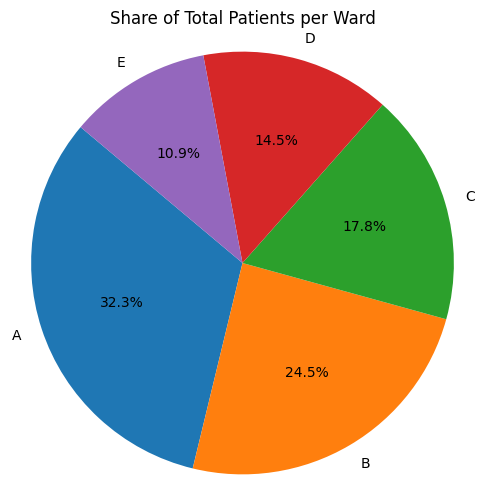

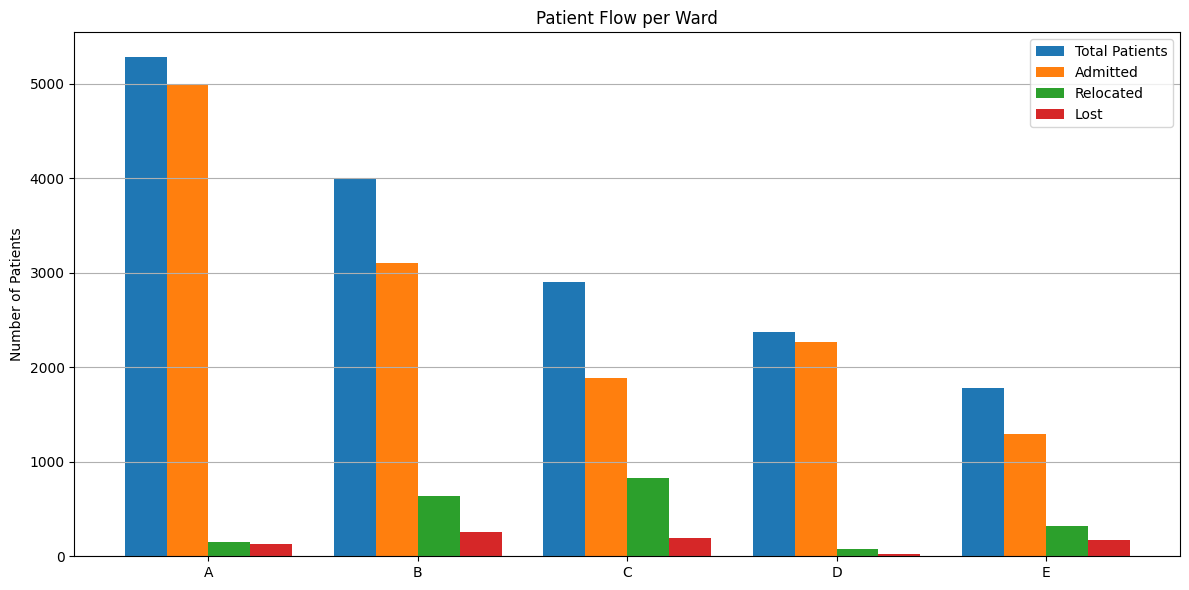

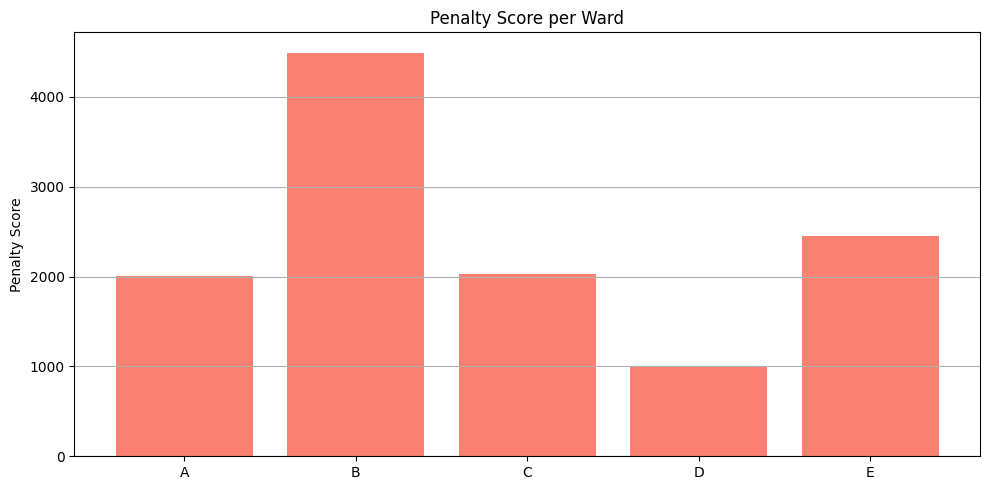

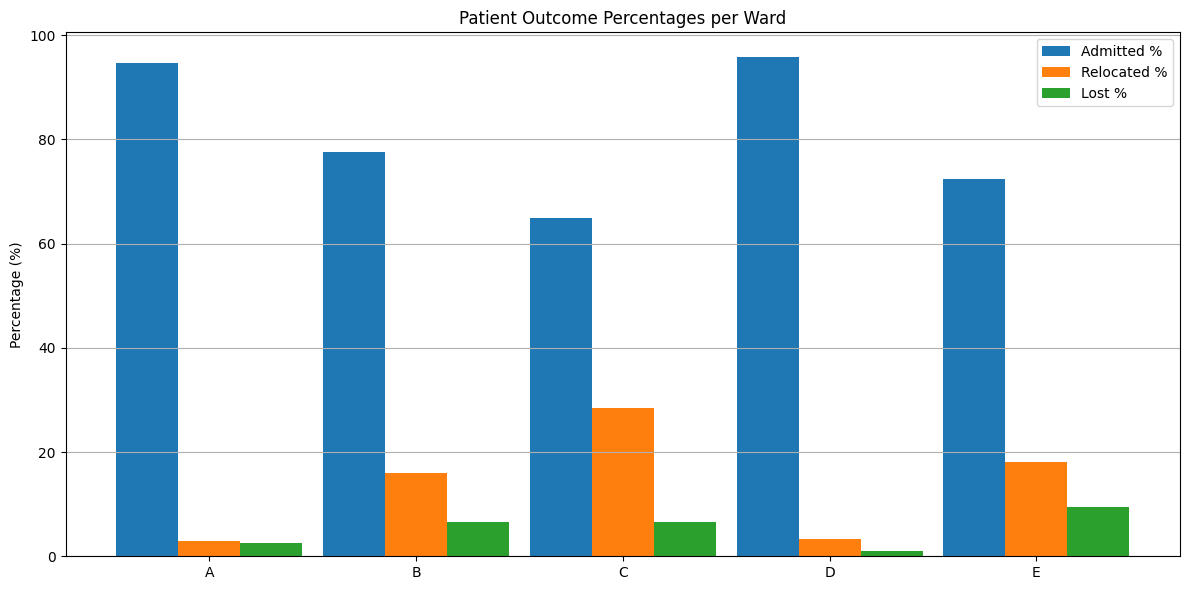

In [ ]:
def plot_penalties(penalties):
    wards = list(penalties.keys())
    scores = [penalties[w] for w in wards]

    plt.figure(figsize=(10, 5))
    plt.bar(wards, scores, color='salmon')
    plt.ylabel('Penalty Score')
    plt.title('Penalty Score per Ward')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


# --- Pie Chart: Share of Total Patients per Ward ---
def plot_pie_total_patients(patients_total):
    labels = patients_total.keys()
    sizes = patients_total.values()

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Share of Total Patients per Ward')
    plt.axis('equal')
    plt.show()

# --- Bar Plot: Percentages of Outcomes per Ward ---
def plot_outcome_percentages(patients_total, patients_admitted, patients_relocated, patients_lost):
    wards = list(patients_total.keys())
    admitted_pct = [patients_admitted[w] / patients_total[w] * 100 if patients_total[w] > 0 else 0 for w in wards]
    relocated_pct = [patients_relocated[w] / patients_total[w] * 100 if patients_total[w] > 0 else 0 for w in wards]
    lost_pct = [patients_lost[w] / patients_total[w] * 100 if patients_total[w] > 0 else 0 for w in wards]

    x = np.arange(len(wards))
    width = 0.3

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, admitted_pct, width, label='Admitted %')
    plt.bar(x, relocated_pct, width, label='Relocated %')
    plt.bar(x + width, lost_pct, width, label='Lost %')

    plt.xticks(x, wards)
    plt.ylabel('Percentage (%)')
    plt.title('Patient Outcome Percentages per Ward')
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# --- Bar Plot: Raw Patient Flow Counts ---
def plot_patient_flow(patients_total, patients_admitted, patients_relocated, patients_lost):
    wards = list(patients_total.keys())
    totals = [patients_total[w] for w in wards]
    admitted = [patients_admitted[w] for w in wards]
    relocated = [patients_relocated[w] for w in wards]
    lost = [patients_lost[w] for w in wards]

    x = np.arange(len(wards))
    width = 0.2

    plt.figure(figsize=(12, 6))
    plt.bar(x - 1.5*width, totals, width, label='Total Patients')
    plt.bar(x - 0.5*width, admitted, width, label='Admitted')
    plt.bar(x + 0.5*width, relocated, width, label='Relocated')
    plt.bar(x + 1.5*width, lost, width, label='Lost')

    plt.xticks(x, wards)
    plt.ylabel('Number of Patients')
    plt.title('Patient Flow per Ward')
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# --- Bar Plot: Penalty Scores per Ward ---
def plot_penalties(penalties):
    wards = list(penalties.keys())
    scores = [penalties[w] for w in wards]

    plt.figure(figsize=(10, 5))
    plt.bar(wards, scores, color='salmon')
    plt.ylabel('Penalty Score')
    plt.title('Penalty Score per Ward')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Run the simulation (returns 6 values)
pt, pa, pr, pl, pen, block = simulate_hospital_flow(days=395, burnin=30)

# Plot results
plot_pie_total_patients(pt)
plot_patient_flow(pt, pa, pr, pl)
plot_penalties(pen)
plot_outcome_percentages(pt, pa, pr, pl)

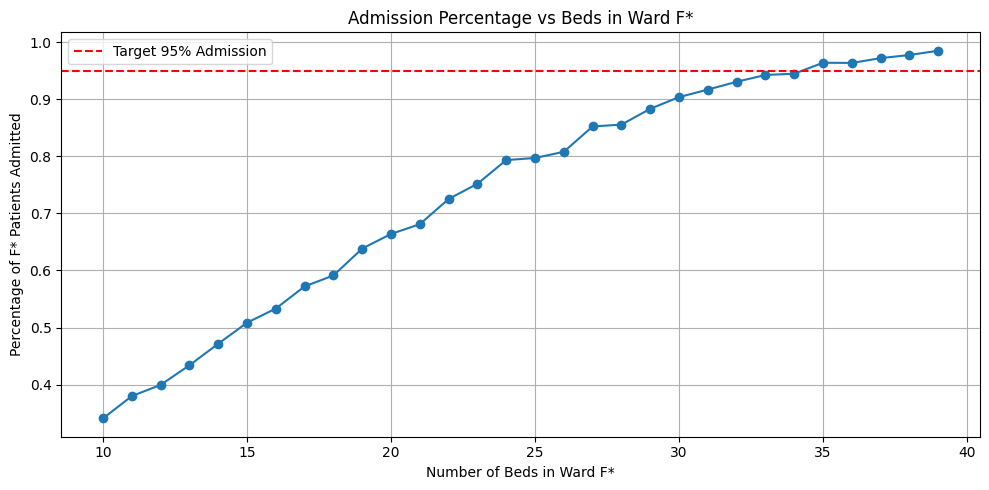

In [34]:
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt

# --- Parameters ---
WARDS = ['A', 'B', 'C', 'D', 'E', 'F']
arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
stay_means = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
relocation_probs = {
    'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
    'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
    'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
    'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
    'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
    'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
}

# --- Helper Functions ---
def initialize_events(days=365):
    event_list = []
    np.random.seed(0)
    for ptype in WARDS:
        num_arrivals = int(arrival_rates[ptype] * days * 1.2)
        interarrival_times = np.random.exponential(1 / arrival_rates[ptype], num_arrivals)
        arrivals = np.cumsum(interarrival_times)
        for t in arrivals:
            if t < days:
                heapq.heappush(event_list, (t, 'Arr', ptype))
    return event_list

def handle_arrival(event, bed, penalties, blocked, event_list, patients_total, patients_admitted, patients_relocated, patients_lost):
    time, _, ptype = event
    patients_total[ptype] += 1
    if bed[ptype] > 0:
        bed[ptype] -= 1
        los = np.random.exponential(stay_means[ptype])
        heapq.heappush(event_list, (time + los, 'Dep', ptype))
        patients_admitted[ptype] += 1
    else:
        penalties[ptype] += urgency_points[ptype]
        dests = list(relocation_probs[ptype].keys())
        probs = list(relocation_probs[ptype].values())
        dest = random.choices(dests, probs)[0]
        heapq.heappush(event_list, (time, 'Tra', (ptype, dest)))
    return bed, penalties, blocked

def handle_departure(event, bed):
    _, _, ptype = event
    bed[ptype] += 1
    return bed

def handle_transfer(event, bed, penalties, blocked, event_list, patients_relocated, patients_lost, patients_admitted):
    time, _, (from_type, dest) = event
    if bed[dest] > 0:
        bed[dest] -= 1
        patients_relocated[from_type] += 1
        patients_admitted[dest] += 1
        los = np.random.exponential(stay_means[from_type])
        heapq.heappush(event_list, (time + los, 'Dep', dest))
    else:
        patients_lost[from_type] += 1
        blocked += 1
    return bed, penalties, blocked

def simulate_hospital_flow(initial_beds, days=365):
    bed = initial_beds.copy()
    penalties = {w: 0 for w in WARDS}
    blocked = 0
    event_list = initialize_events(days)

    patients_total = {w: 0 for w in WARDS}
    patients_admitted = {w: 0 for w in WARDS}
    patients_relocated = {w: 0 for w in WARDS}
    patients_lost = {w: 0 for w in WARDS}

    while event_list:
        event = heapq.heappop(event_list)
        event_type = event[1]

        if event_type == 'Arr':
            bed, penalties, blocked = handle_arrival(event, bed, penalties, blocked, event_list,
                                                     patients_total, patients_admitted, patients_relocated, patients_lost)
        elif event_type == 'Dep':
            bed = handle_departure(event, bed)
        elif event_type == 'Tra':
            bed, penalties, blocked = handle_transfer(event, bed, penalties, blocked, event_list,
                                                      patients_relocated, patients_lost, patients_admitted)

    return patients_total, patients_admitted, patients_relocated, patients_lost, penalties, blocked

# --- Run over different allocations to F ---
results = []
total_beds = 165
for f_beds in range(10, 40):
    other_beds = total_beds - f_beds
    share = other_beds / 5
    initial_beds = {'A': int(share), 'B': int(share), 'C': int(share), 'D': int(share), 'E': total_beds - f_beds - 4*int(share), 'F': f_beds}
    pt, pa, pr, pl, pen, block = simulate_hospital_flow(initial_beds)
    admitted_pct = pa['F'] / pt['F'] if pt['F'] > 0 else 0
    results.append((f_beds, pt['F'], pa['F'], pr['F'], pl['F'], round(admitted_pct, 4)))

results

# Extract data for plotting
f_beds_vals = [r[0] for r in results]
admit_pct = [r[-1] for r in results]

# Plot admission percentage vs number of F beds
plt.figure(figsize=(10, 5))
plt.plot(f_beds_vals, admit_pct, marker='o', linestyle='-')
plt.axhline(0.95, color='red', linestyle='--', label='Target 95% Admission')
plt.xlabel('Number of Beds in Ward F*')
plt.ylabel('Percentage of F* Patients Admitted')
plt.title('Admission Percentage vs Beds in Ward F*')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
